# Roadmap Epigenomics ChIP 3 kb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
import json
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'
size = '3kb'
name = 'roadmap-chip-{}-init'.format(size)
settings_filepath = 'settings-roadmap-epigenomics-chip-histone-mod-{}.json'.format(size)
search_name = 'cnn-final'
search_filepath = '{}.json'.format(search_name)
datasets_filepath = "datasets-chip-histone-mod-hg19-half.json"

with open(os.path.join(base, settings_filepath), "r") as f:
    settings = json.load(f)

with open(os.path.join(base, search_filepath), "r") as f:
    search = json.load(f)
    
dataset = 'roadmap-chip_w-{}_f-{}_r-{}-half'.format(
    settings['window_size'],
    settings['step_frequency'],
    settings['resolution'],
)

with h5py.File(os.path.join(base, 'data', '{}.h5'.format(dataset)), 'r') as f:
    print()
    print('Dataset: {}'.format(dataset))
    print('Training samples: {}'.format(f['data_train'].shape[0]),)
    print('Dev samples: {}'.format(f['data_dev'].shape[0]))
    print('Test samples: {}'.format(f['data_test'].shape[0]))
    print('---')
    print('Total samples: {}'.format(f['data_train'].shape[0] + f['data_dev'].shape[0] + f['data_test'].shape[0]))


Dataset: roadmap-chip_w-3000_f-2_r-25-half
Training samples: 22750529
Dev samples: 2007401
Test samples: 2007413
---
Total samples: 26765343


## Check if data is available

In [23]:
"""Check if all narrowPeak and broadPeak files have been converted to bigBeds"""

import h5py
import pathlib

try:
    with open(os.path.join(base, datasets_filepath), "r") as f:
        all_datasets = json.load(f)
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the Roadmap Epigenomics experiments?")

not_found = []

for e_id in all_datasets:
    for target in settings["targets"]:
        infile = '../data/{}-{}.narrowPeak.gz'.format(e_id, target)
        outfile = '../data/{}-{}.peaks.narrow.bigBed'.format(e_id, target)
        
        if not pathlib.Path(outfile).is_file():
            not_found.append((infile, outfile))
            
        infile = '../data/{}-{}.broadPeak.gz'.format(e_id, target)
        outfile = '../data/{}-{}.peaks.broad.bigBed'.format(e_id, target)
        
        if not pathlib.Path(outfile).is_file():
            not_found.append((infile, outfile))

print("{} are not found".format(len(not_found)))

0 are not found


## Prepare data

In [27]:
from prepare import prepare_jobs

prepare_jobs(
    'ChIP',
    datasets_filepath,
    settings_filepath,
    roadmap=True,
    base=base,
    clear=False,
    verbose=False,
)

Created a slurm file for preparing 49 datasets


Run `sbatch prepare.slurm`

## Check if all datasets have been prepared

In [2]:
import h5py

try:
    with open(os.path.join(base, datasets_filepath), "r") as f:
        all_datasets = json.load(f)
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(
        base,
        'data',
        '{}_w-{}_f-{}_r-{}.h5'.format(
            dataset,
            settings["window_size"],
            settings["step_frequency"],
            settings["resolution"]
        )
    )
    total_size += os.path.getsize(filepath)
    try:
        with h5py.File(filepath, "r") as f:
            try:
                x = f['data_train']
                x = f['data_dev']
                x = f['data_test']
                x = f['peaks_train']
                x = f['peaks_dev']
                x = f['peaks_test']
                x = f['shuffling']
                x = f['settings']
            except KeyError:
                outdated.append(dataset)
    except OSError:
        not_found.append(dataset)

print("{} are not found".format(len(not_found)))
print("{} are not outdated".format(len(outdated)))

0 are not found
0 are not outdated


## Merge datasets

See `merge-chip-3kb.slurm` and `merge-chip-3kb-cnn-search.slurm`

## Create training jobs

In [24]:
from jobs import jobs

jobs(
    search_filepath,
    settings_filepath,
    dataset=dataset,
    name=name,
    cluster='cox',
    epochs=5,
    batch_size=256,
    repeat=3,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 1 neural networks


#### Check training

In [26]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name, 'training', dataset, base=base
)

if okay:
    print('Trainings completed')
else:
    print('Trainings did not finish. Missing {}'.format(len(not_found)))

Trainings completed


## Create evaluation jobs

In [27]:
from evaluate import create_jobs

create_jobs(
    search_name,
    name=name,
    dataset=dataset,
    cluster='seasdgx1',
    base=base,
    incl_dtw=False,
)

Created slurm file for evaluating 3 neural networks


In a terminal run: `sbatch evaluate-cnn-final-test.slurm`

In [28]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name, 'evaluation', dataset, base=base
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


## Compare

num_models 3


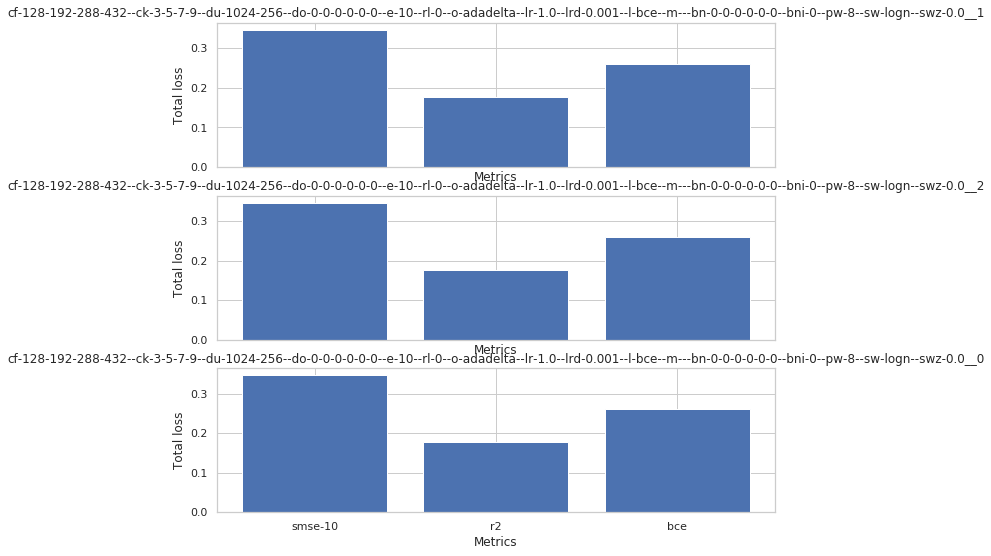

In [30]:
from compare import compare
    
performance = compare(
    'definitions-{}.json'.format(search_name),
    dataset_name=dataset,
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [31]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Repetition #1


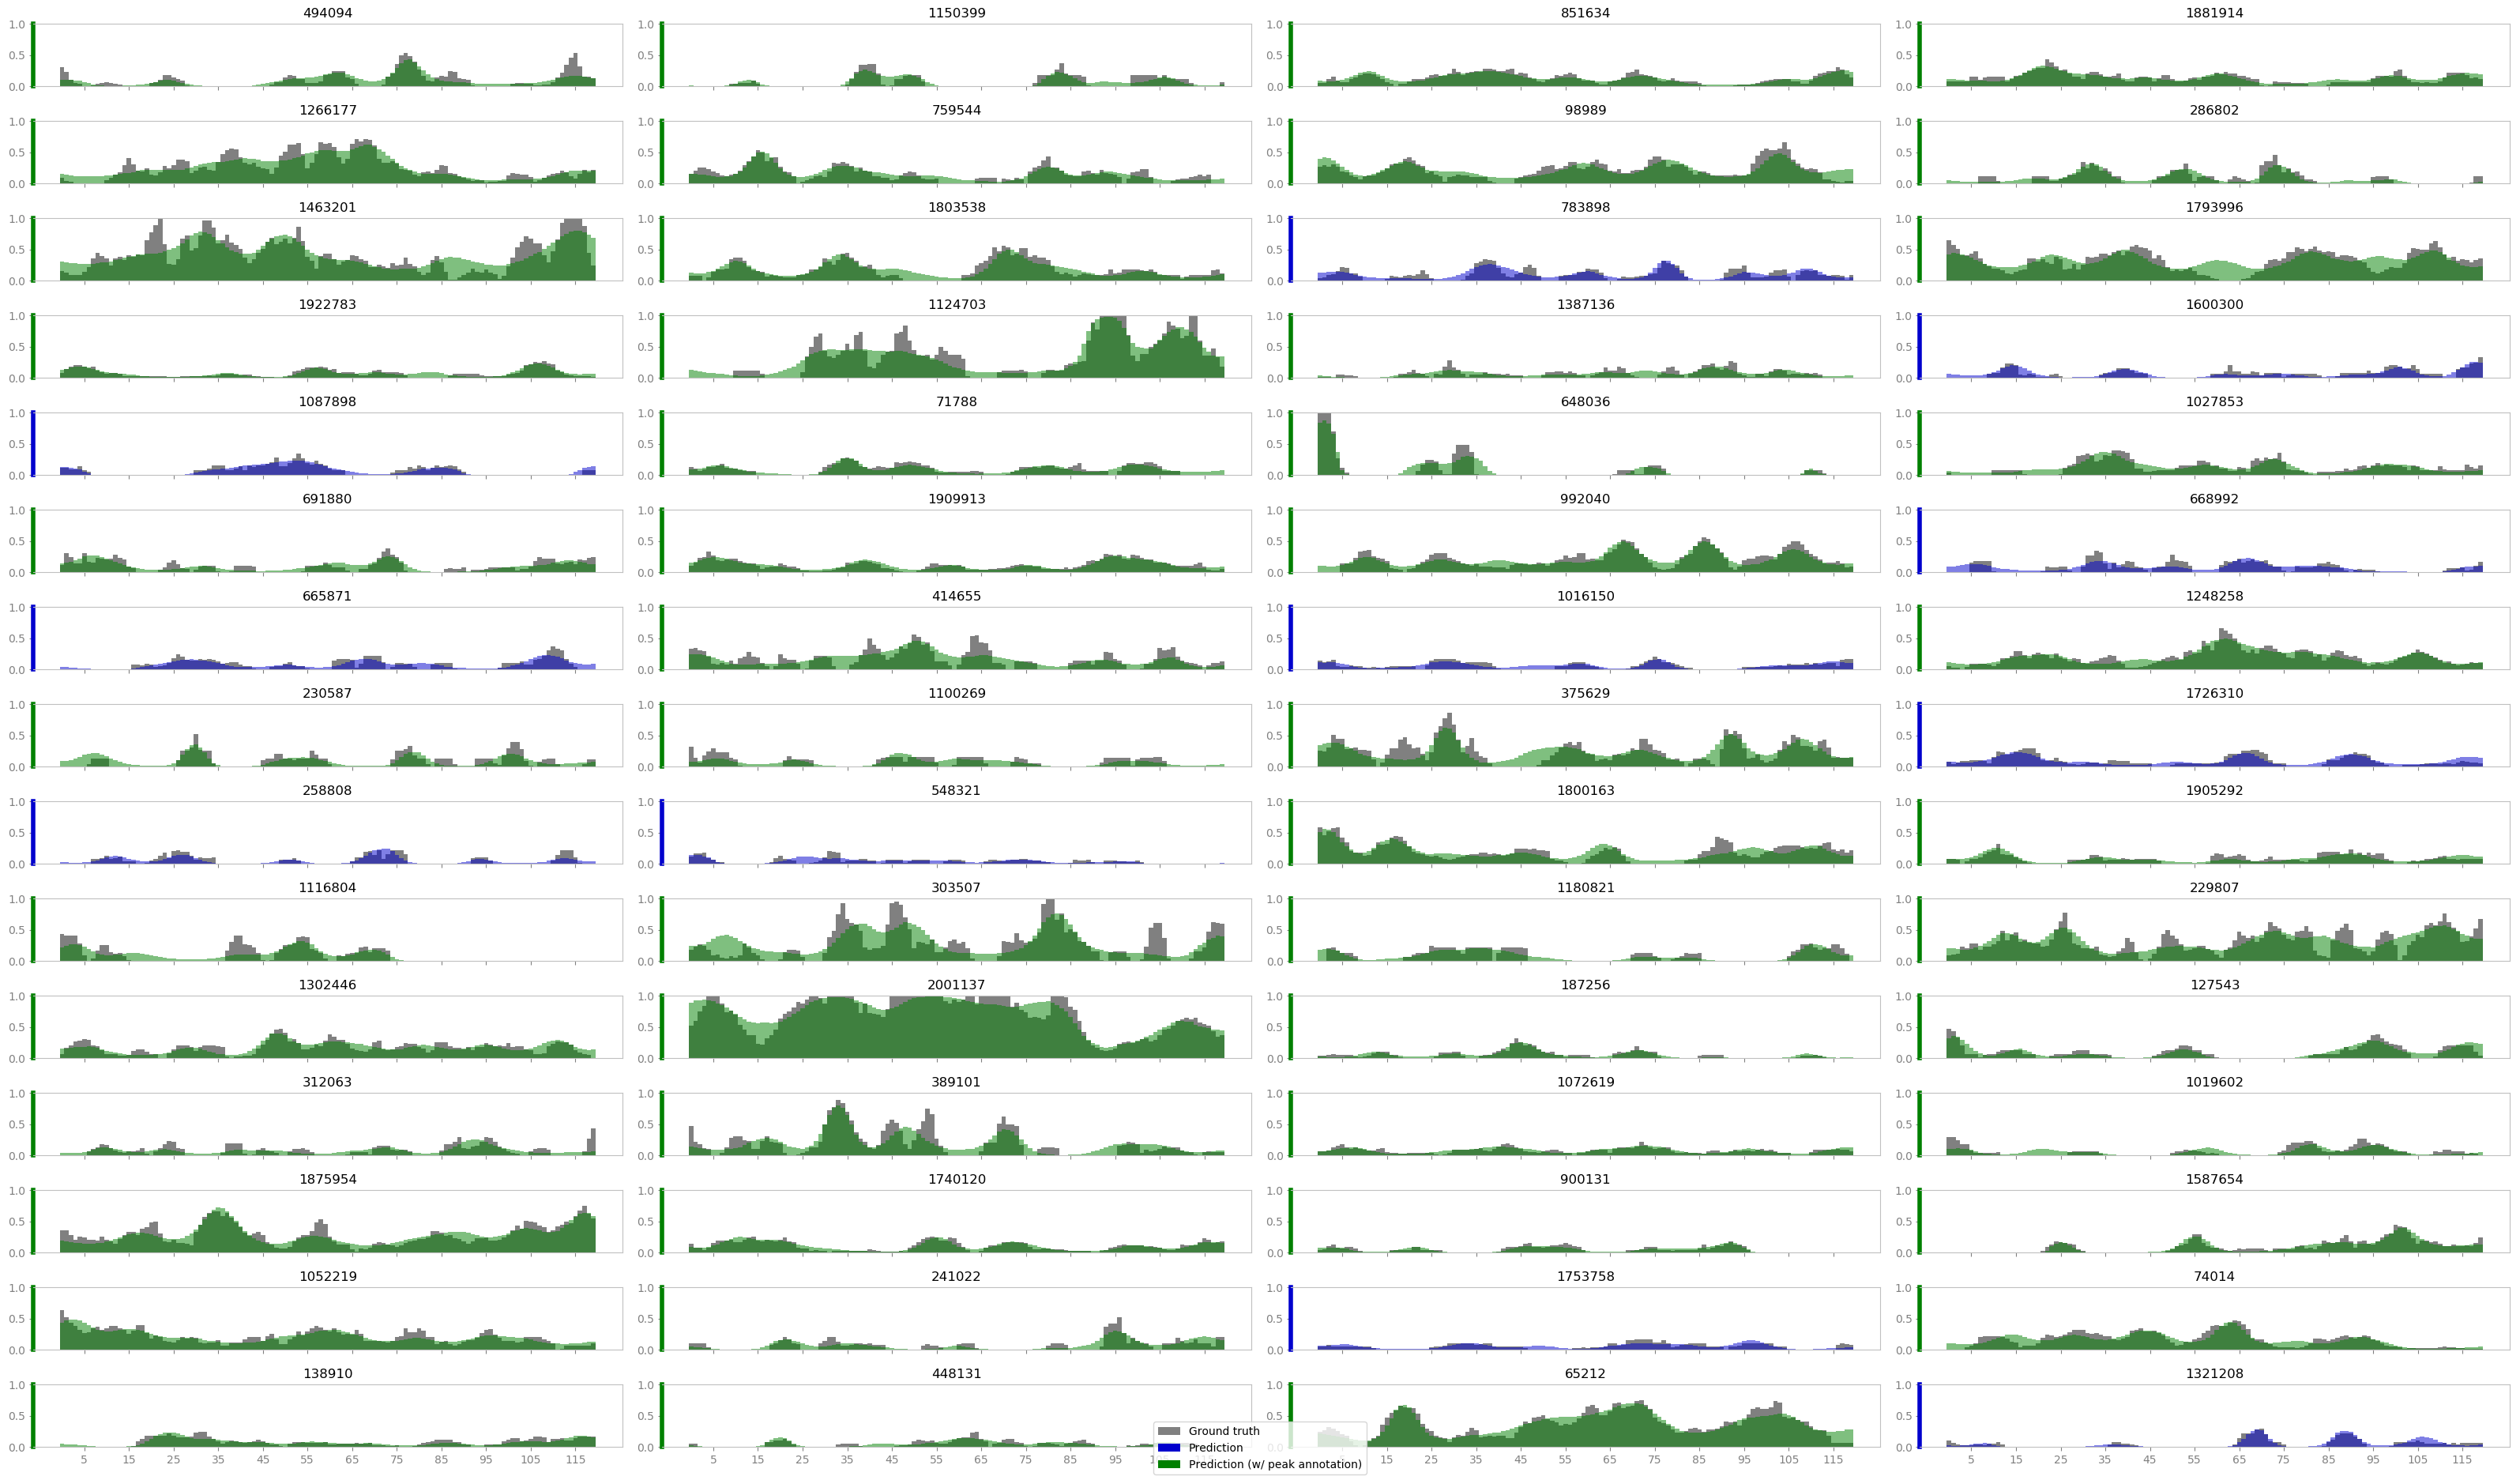

Repetition #2


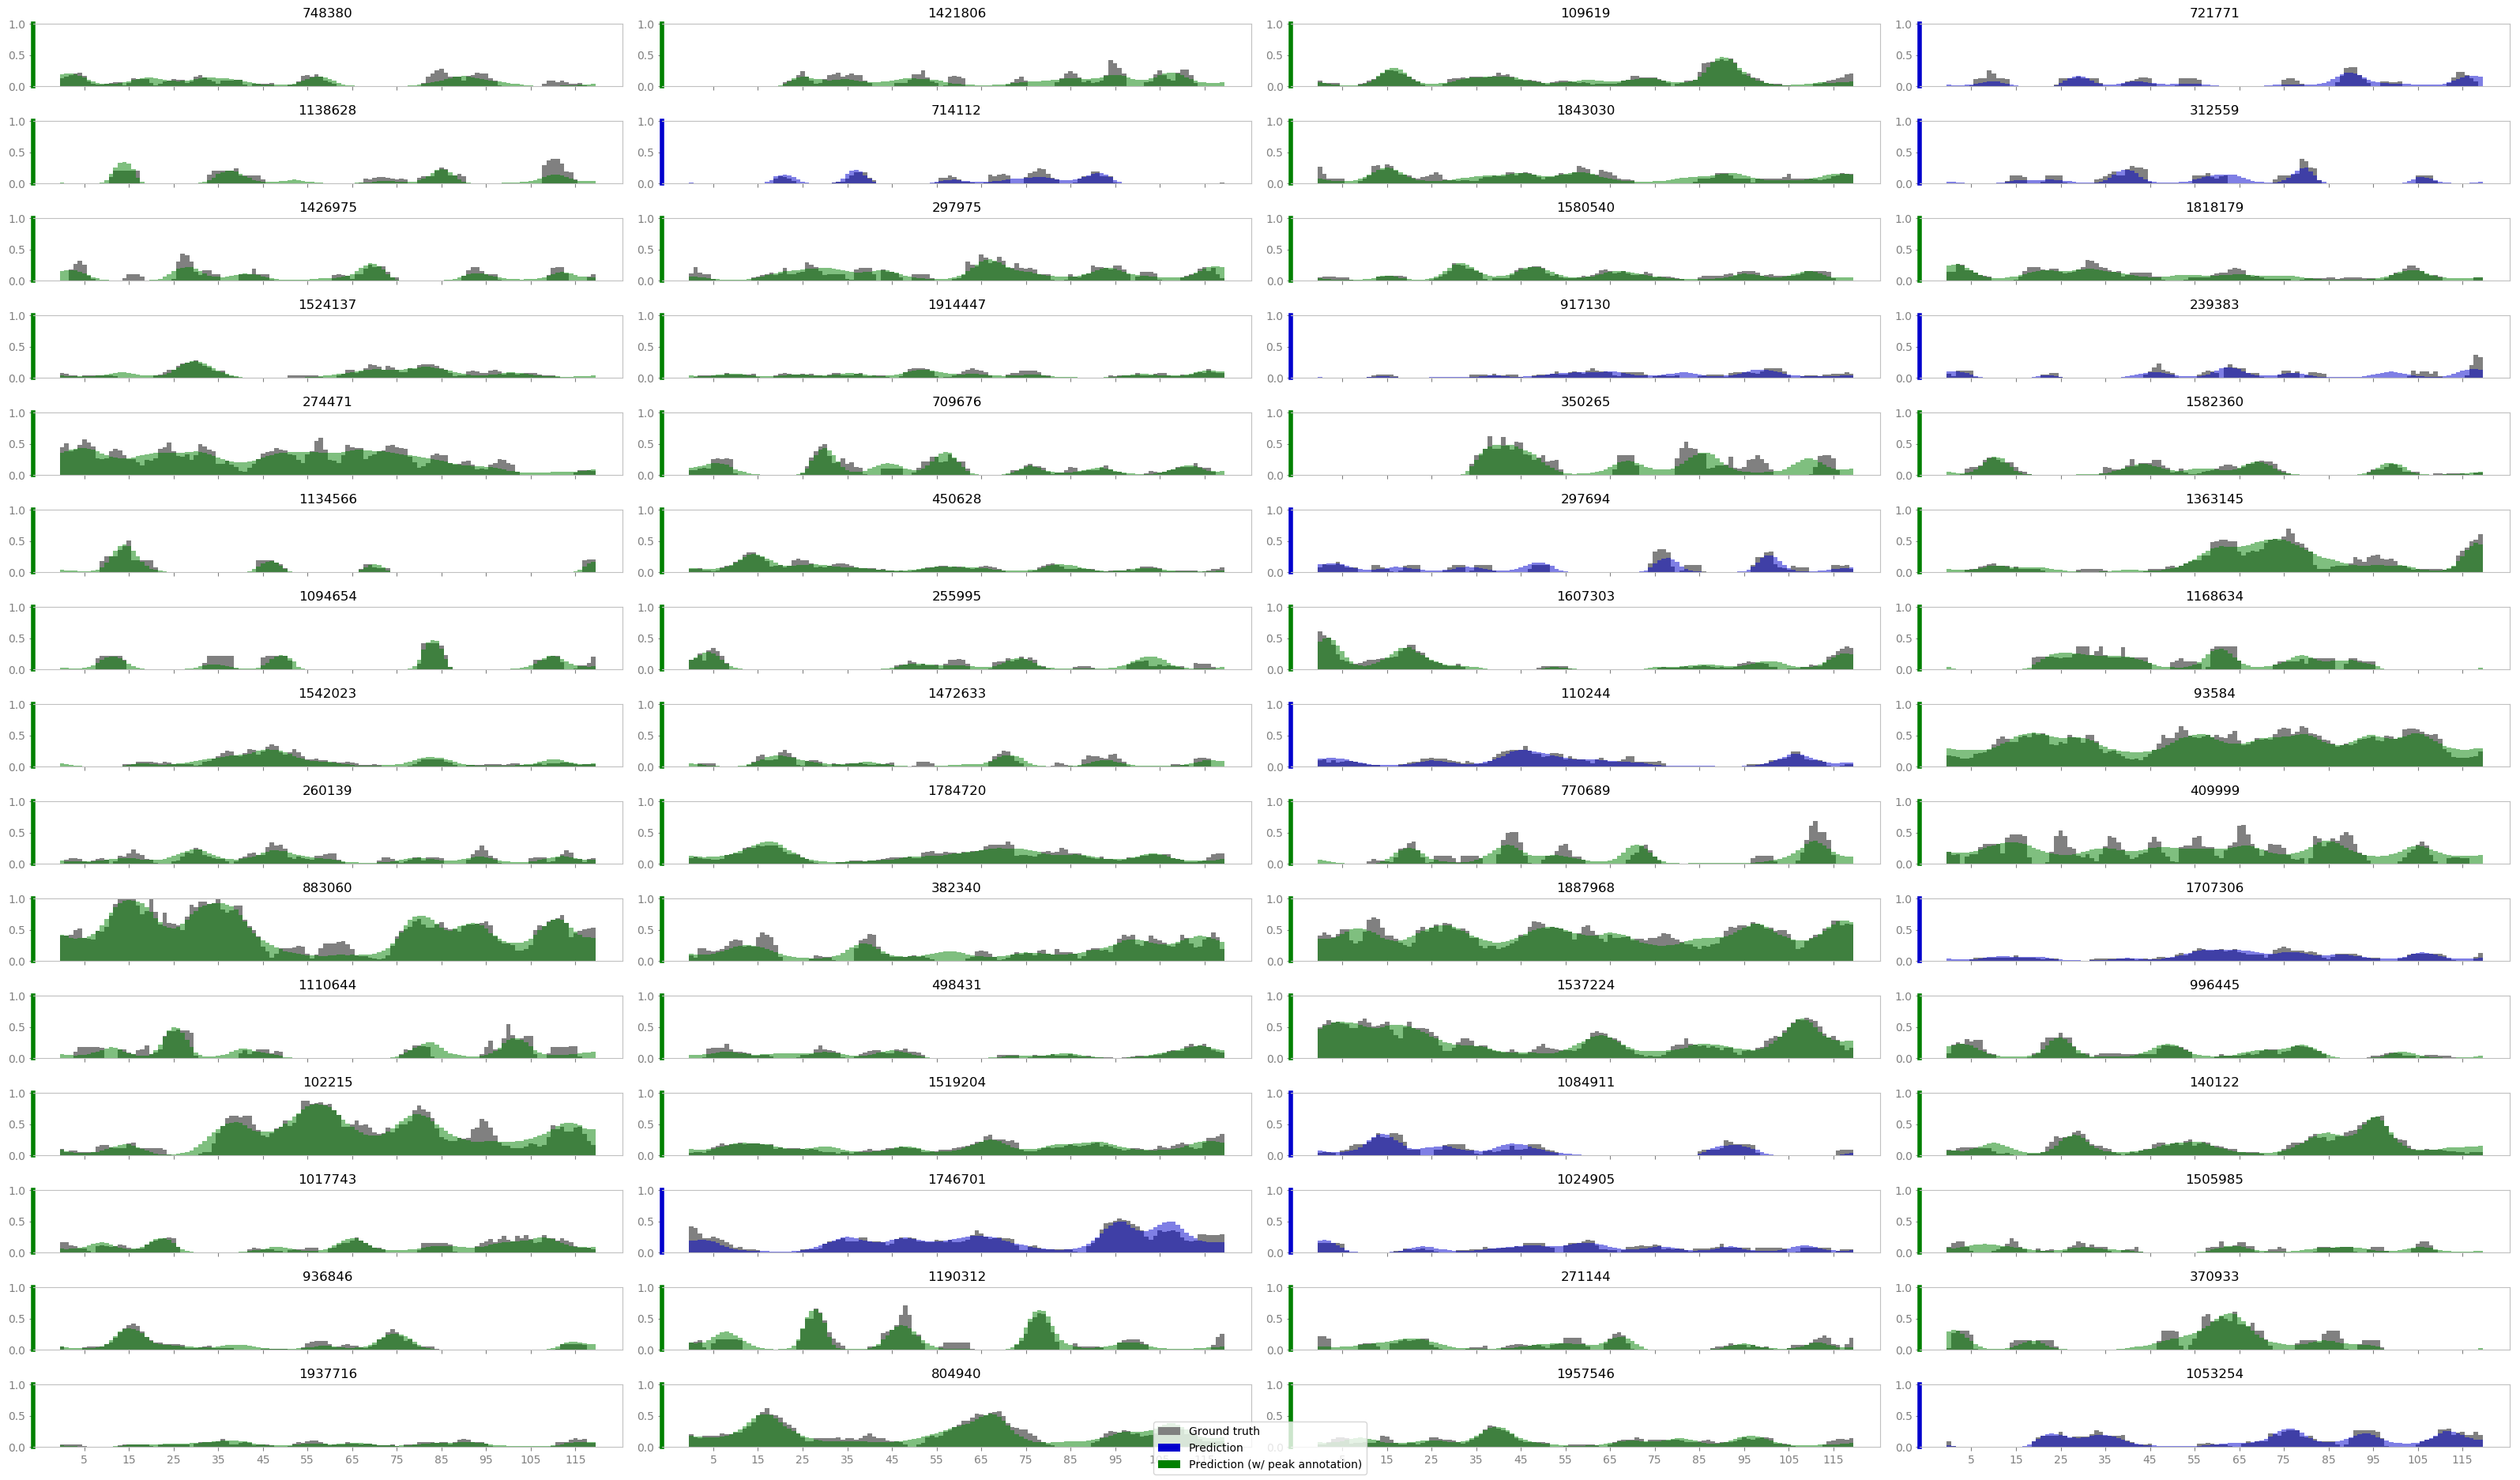

Repetition #0


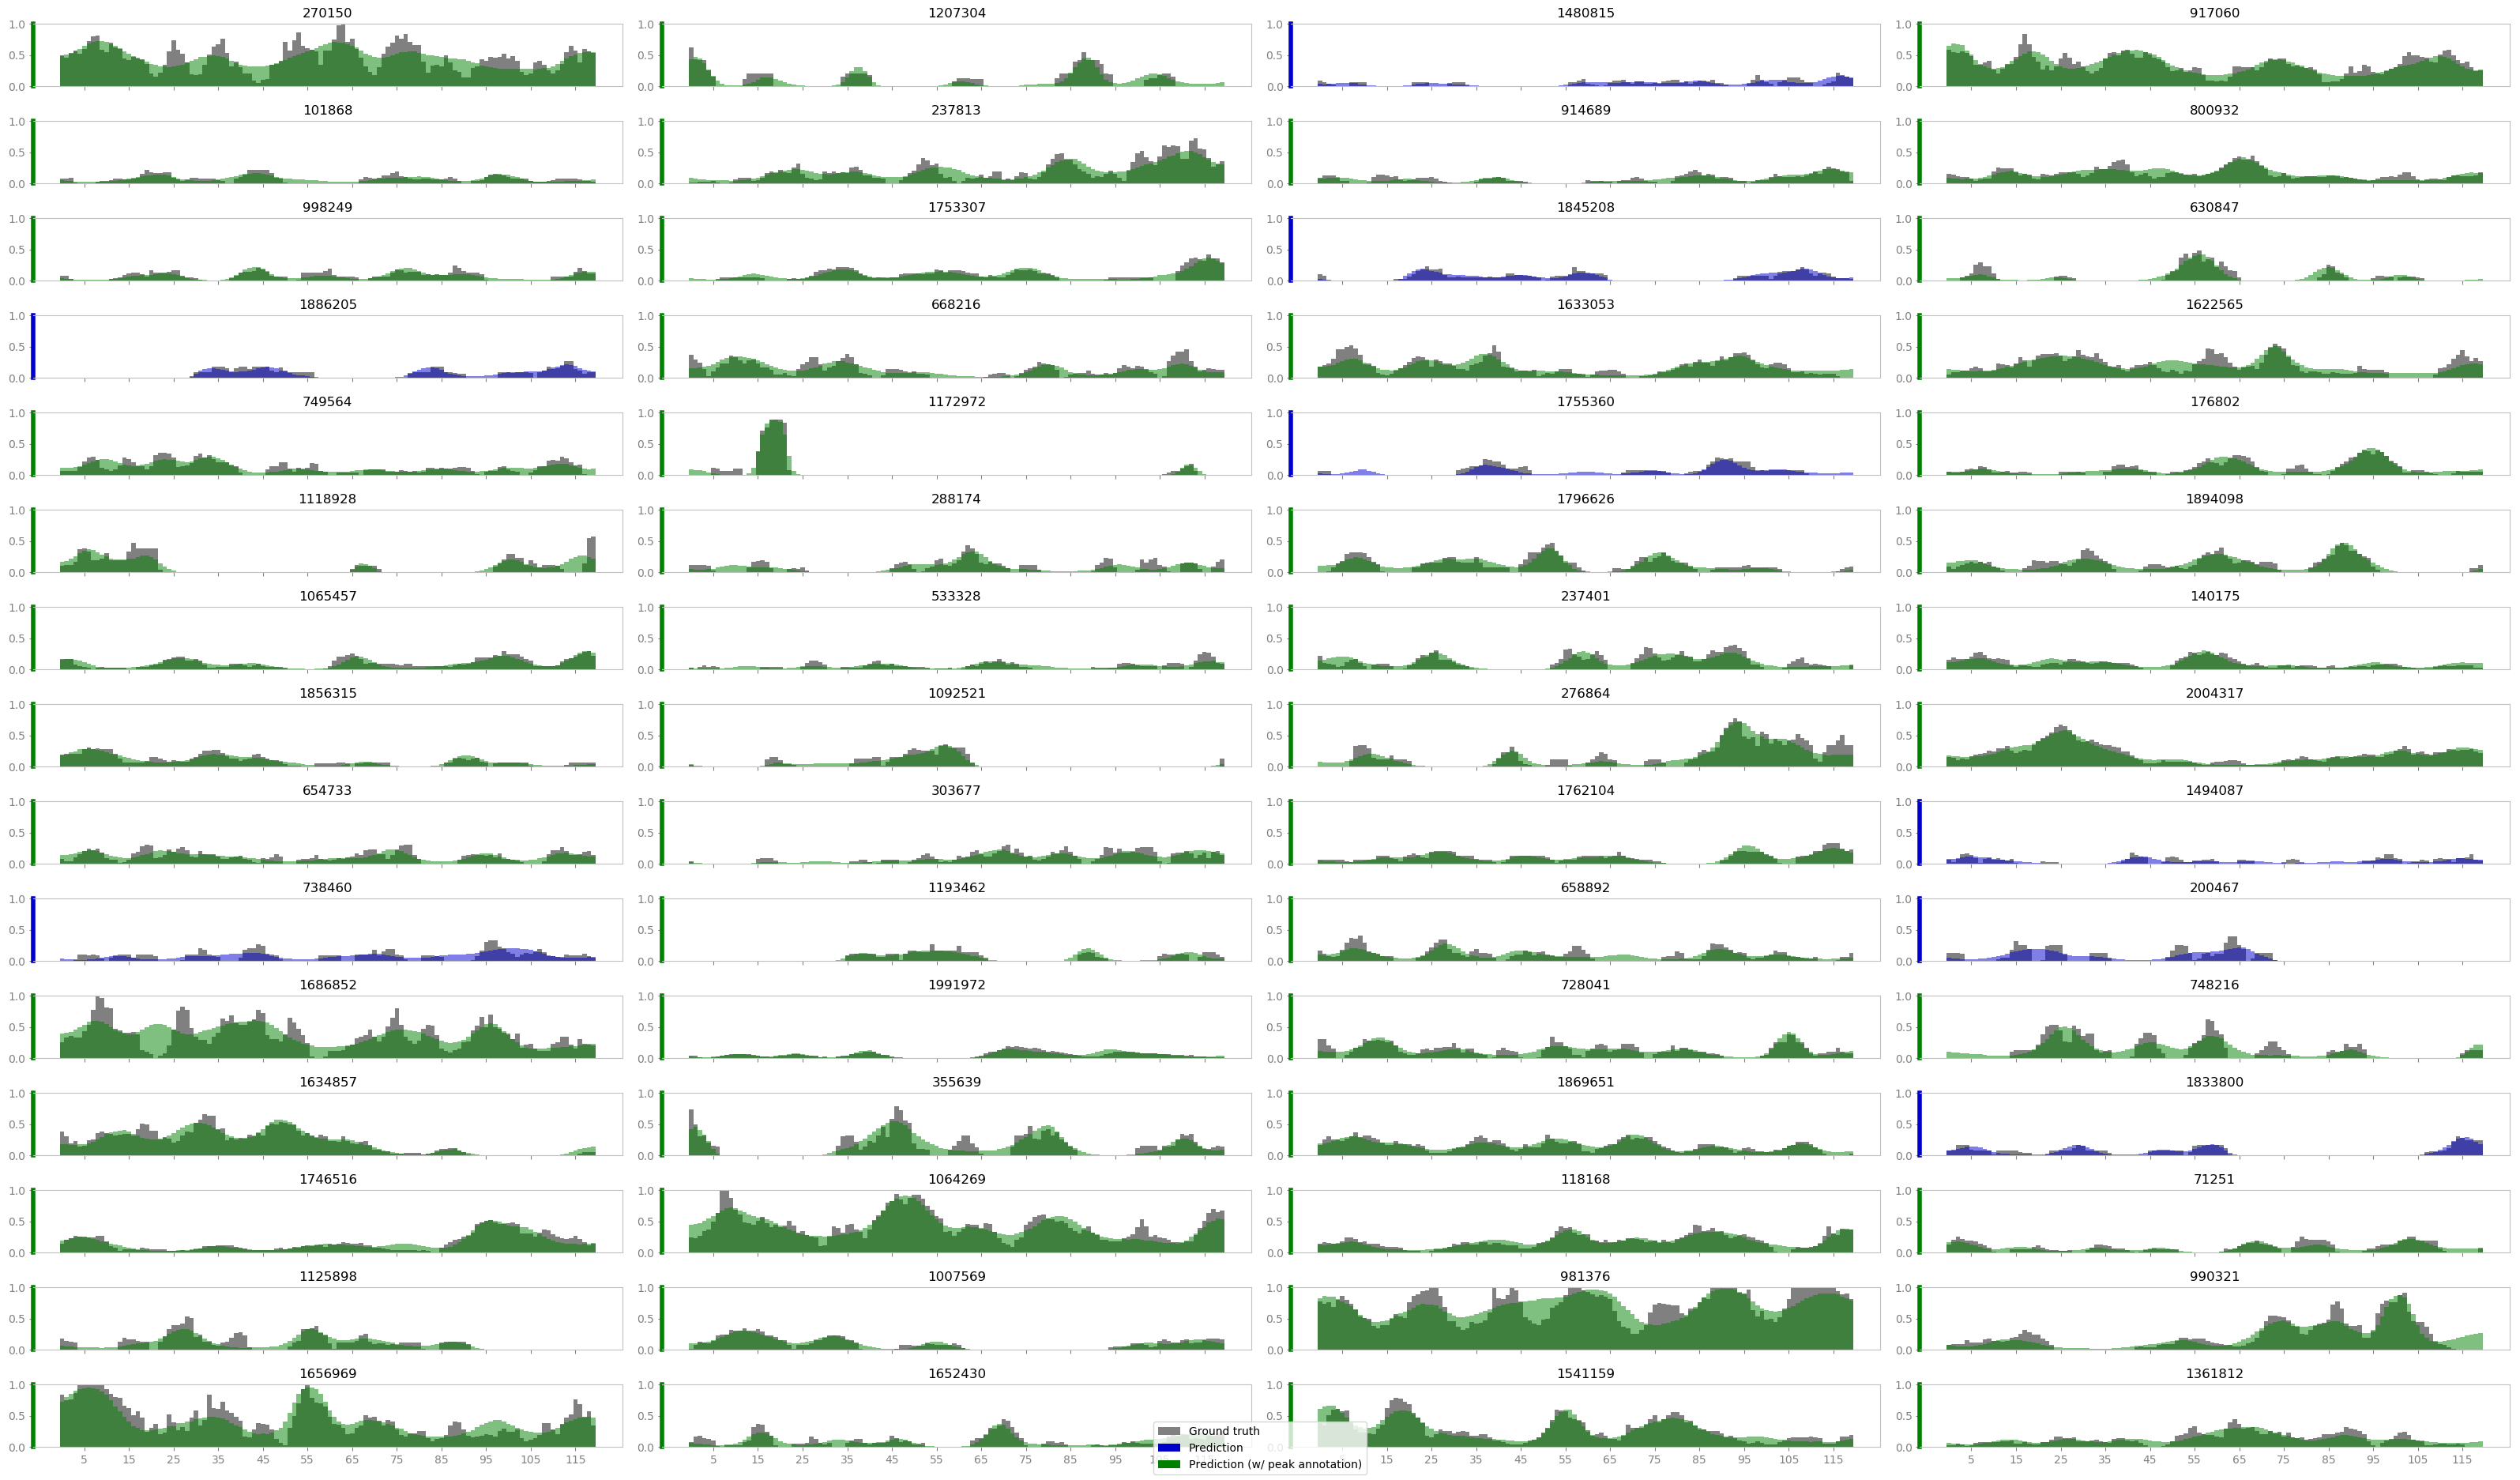

In [32]:
from IPython.core.display import Image, display
from itertools import takewhile


with open(os.path.join(base, 'definitions-{}.json'.format(search_name)), 'r') as f:
    definitions = json.load(f)

lcp = ''.join(c[0] for c in takewhile(lambda x: all(x[0] == y for y in x), zip(*definitions)))

for model in qgw.get_selected_df().iterrows():
    model_name, repetition = (lcp + model[0]).split('__')
    print('Repetition #{}'.format(repetition))
    display(Image(os.path.join(base, 'models', '{}---predictions-{}__{}.png'.format(model_name, dataset, repetition))))

### The following section subscribes the subsampled datasets for the 3KB CAE

The goal is to create a dataset of roughly 50% the original data (=24 expriments) with a good balance between samples

In [16]:
with open('../datasets-chip-histone-mod-hg19.json', 'r') as f:
    datasets = json.load(f)

all_ds = {
  'header': ['GROUP', 'COLOR', 'MNEMONIC', 'STD_NAME', 'EDACC_NAME', 'ANATOMY', 'TYPE', 'AGE', 'SEX', 'SOLID_LIQUID', 'ETHNICITY', 'SINGLEDONOR_COMPOSITE'],
  'E001': ['ESC', '#924965', 'ESC.I3', 'ES-I3 Cells', 'ES-I3_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E002': ['ESC', '#924965', 'ESC.WA7', 'ES-WA7 Cells', 'ES-WA7_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E003': ['ESC', '#924965', 'ESC.H1', 'H1 Cells', 'H1_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E004': ['ES-deriv', '#4178AE', 'ESDR.H1.BMP4.MESO', 'H1 BMP4 Derived Mesendoderm Cultured Cells', 'H1_BMP4_Derived_Mesendoderm_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E005': ['ES-deriv', '#4178AE', 'ESDR.H1.BMP4.TROP', 'H1 BMP4 Derived Trophoblast Cultured Cells', 'H1_BMP4_Derived_Trophoblast_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E006': ['ES-deriv', '#4178AE', 'ESDR.H1.MSC', 'H1 Derived Mesenchymal Stem Cells', 'H1_Derived_Mesenchymal_Stem_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E007': ['ES-deriv', '#4178AE', 'ESDR.H1.NEUR.PROG', 'H1 Derived Neuronal Progenitor Cultured Cells', 'H1_Derived_Neuronal_Progenitor_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E008': ['ESC', '#924965', 'ESC.H9', 'H9 Cells', 'H9_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E009': ['ES-deriv', '#4178AE', 'ESDR.H9.NEUR.PROG', 'H9 Derived Neuronal Progenitor Cultured Cells', 'H9_Derived_Neuronal_Progenitor_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E010': ['ES-deriv', '#4178AE', 'ESDR.H9.NEUR', 'H9 Derived Neuron Cultured Cells', 'H9_Derived_Neuron_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E011': ['ES-deriv', '#4178AE', 'ESDR.CD184.ENDO', 'hESC Derived CD184+ Endoderm Cultured Cells', 'hESC_Derived_CD184+_Endoderm_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E012': ['ES-deriv', '#4178AE', 'ESDR.CD56.ECTO', 'hESC Derived CD56+ Ectoderm Cultured Cells', 'hESC_Derived_CD56+_Ectoderm_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E013': ['ES-deriv', '#4178AE', 'ESDR.CD56.MESO', 'hESC Derived CD56+ Mesoderm Cultured Cells', 'hESC_Derived_CD56+_Mesoderm_Cultured_Cells', 'ESC_DERIVED', 'ESCDerived', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E014': ['ESC', '#924965', 'ESC.HUES48', 'HUES48 Cells', 'HUES48_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E015': ['ESC', '#924965', 'ESC.HUES6', 'HUES6 Cells', 'HUES6_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E016': ['ESC', '#924965', 'ESC.HUES64', 'HUES64 Cells', 'HUES64_Cell_Line', 'ESC', 'PrimaryCulture', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E017': ['IMR90', '#E41A1C', 'LNG.IMR90', 'IMR90 fetal lung fibroblasts Cell Line', 'IMR90_Cell_Line', 'LUNG', 'CellLine', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E018': ['iPSC', '#69608A', 'IPSC.15b', 'iPS-15b Cells', 'iPS-15b_Cell_Line', 'IPSC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E019': ['iPSC', '#69608A', 'IPSC.18', 'iPS-18 Cells', 'iPS-18_Cell_Line', 'IPSC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E020': ['iPSC', '#69608A', 'IPSC.20B', 'iPS-20b Cells', 'iPS-20b_Cell_Line', 'IPSC', 'PrimaryCulture', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E021': ['iPSC', '#69608A', 'IPSC.DF.6.9', 'iPS DF 6.9 Cells', 'iPS_DF_6.9_Cell_Line', 'IPSC', 'PrimaryCulture', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E022': ['iPSC', '#69608A', 'IPSC.DF.19.11', 'iPS DF 19.11 Cells', 'iPS_DF_19.11_Cell_Line', 'IPSC', 'PrimaryCulture', 'CL', 'Male', 'NA', 'NA', 'SD'],
  'E023': ['Mesench', '#B65C73', 'FAT.MSC.DR.ADIP', 'Mesenchymal Stem Cell Derived Adipocyte Cultured Cells', 'Mesenchymal_Stem_Cell_Derived_Adipocyte_Cultured_Cells', 'FAT', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E024': ['ESC', '#924965', 'ESC.4STAR', 'ES-UCSF4 Cells', '4star', 'ESC', 'PrimaryCulture', 'CL', 'Female', 'NA', 'NA', 'SD'],
  'E025': ['Mesench', '#B65C73', 'FAT.ADIP.DR.MSC', 'Adipose Derived Mesenchymal Stem Cell Cultured Cells', 'Adipose_Derived_Mesenchymal_Stem_Cell_Cultured_Cells', 'FAT', 'PrimaryCulture', '"31Y, 59Y, 41Y"', 'Female', 'SOLID', 'Unknown', 'C'],
  'E026': ['Mesench', '#B65C73', 'STRM.MRW.MSC', 'Bone Marrow Derived Cultured Mesenchymal Stem Cells', 'Bone_Marrow_Derived_Mesenchymal_Stem_Cell_Cultured_Cells', 'STROMAL_CONNECTIVE', 'PrimaryCulture', '"57Y, unknown, unkown, unkown"', 'Unknown', 'SOLID', 'Unknown', 'SD'],
  'E027': ['Epithelial', '#FF9D0C', 'BRST.MYO', 'Breast Myoepithelial Primary Cells', 'Breast_Myoepithelial_Cells', 'BREAST', 'PrimaryCell', '"36Y,33Y"', 'Female', 'SOLID', '"African-American, African-American"', 'C'],
  'E028': ['Epithelial', '#FF9D0C', 'BRST.HMEC.35', 'Breast variant Human Mammary Epithelial Cells (vHMEC)', 'Breast_vHMEC', 'BREAST', 'PrimaryCulture', '18Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E029': ['HSC & B-cell', '#678C69', 'BLD.CD14.PC', 'Primary monocytes from peripheral blood', 'CD14_Primary_Cells', 'BLOOD', 'PrimaryCell', '"21Y, 37Y"', 'Male', 'LIQUID', '"Hispanic, Unknown"', 'C'],
  'E030': ['HSC & B-cell', '#678C69', 'BLD.CD15.PC', 'Primary neutrophils from peripheral blood', 'CD15_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Male', 'LIQUID', 'Unknown', 'SD'],
  'E031': ['HSC & B-cell', '#678C69', 'BLD.CD19.CPC', 'Primary B cells from cord blood', 'CD19_Primary_Cells_Cord_BI', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Mixed', 'LIQUID', 'Unknown', 'C'],
  'E032': ['HSC & B-cell', '#678C69', 'BLD.CD19.PPC', 'Primary B cells from peripheral blood', 'CD19_Primary_Cells_Peripheral_UW', 'BLOOD', 'PrimaryCell', '"21Y, 37Y"', 'Male', 'LIQUID', '"Caucasian, Hispanic"', 'C'],
  'E033': ['Blood & T-cell', '#55A354', 'BLD.CD3.CPC', 'Primary T cells from cord blood', 'CD3_Primary_Cells_Cord_BI', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E034': ['Blood & T-cell', '#55A354', 'BLD.CD3.PPC', 'Primary T cells from peripheral blood', 'CD3_Primary_Cells_Peripheral_UW', 'BLOOD', 'PrimaryCell', '"21Y, 37Y"', 'Male', 'LIQUID', '"Caucasian, Hispanic"', 'C'],
  'E035': ['HSC & B-cell', '#678C69', 'BLD.CD34.PC', 'Primary hematopoietic stem cells', 'CD34_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E036': ['HSC & B-cell', '#678C69', 'BLD.CD34.CC', 'Primary hematopoietic stem cells short term culture', 'CD34_Cultured_Cells', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E037': ['Blood & T-cell', '#55A354', 'BLD.CD4.MPC', 'Primary T helper memory cells from peripheral blood 2', 'CD4_Memory_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E038': ['Blood & T-cell', '#55A354', 'BLD.CD4.NPC', 'Primary T helper naive cells from peripheral blood', 'CD4_Naive_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Mixed', 'LIQUID', 'Unknown', 'C'],
  'E039': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25M.CD45RA.NPC', 'Primary T helper naive cells from peripheral blood', 'CD4+_CD25-_CD45RA+_Naive_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E040': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25M.CD45RO.MPC', 'Primary T helper memory cells from peripheral blood 1', 'CD4+_CD25-_CD45RO+_Memory_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E041': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25M.IL17M.PL.TPC', 'Primary T helper cells PMA-I stimulated', 'CD4+_CD25-_IL17-_PMA-Ionomycin_stimulated_MACS_purified_Th_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E042': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25M.IL17P.PL.TPC', 'Primary T helper 17 cells PMA-I stimulated', 'CD4+_CD25-_IL17+_PMA-Ionomcyin_stimulated_Th17_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E043': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25M.TPC', 'Primary T helper cells from peripheral blood', 'CD4+_CD25-_Th_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E044': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25.CD127M.TREGPC', 'Primary T regulatory cells from peripheral blood', 'CD4+_CD25+_CD127-_Treg_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E045': ['Blood & T-cell', '#55A354', 'BLD.CD4.CD25I.CD127.TMEMPC', 'Primary T cells effector/memory enriched from peripheral blood', 'CD4+_CD25int_CD127+_Tmem_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E046': ['HSC & B-cell', '#678C69', 'BLD.CD56.PC', 'Primary Natural Killer cells from peripheral blood', 'CD56_Primary_Cells', 'BLOOD', 'PrimaryCell', '"21Y, 37Y"', 'Male', 'LIQUID', '"Caucasian, Hispanic"', 'C'],
  'E047': ['Blood & T-cell', '#55A354', 'BLD.CD8.NPC', 'Primary T CD8+ naive cells from peripheral blood', 'CD8_Naive_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Mixed', 'LIQUID', 'Unknown', 'C'],
  'E048': ['Blood & T-cell', '#55A354', 'BLD.CD8.MPC', 'Primary T CD8+ memory cells from peripheral blood', 'CD8_Memory_Primary_Cells', 'BLOOD', 'PrimaryCell', 'Unknown', 'Unknown', 'LIQUID', 'Unknown', 'C'],
  'E049': ['Mesench', '#B65C73', 'STRM.CHON.MRW.DR.MSC', 'Mesenchymal Stem Cell Derived Chondrocyte Cultured Cells', 'Chondrocytes_from_Bone_Marrow_Derived_Mesenchymal_Stem_Cell_Cultured_Cells', 'STROMAL_CONNECTIVE', 'PrimaryCulture', 'Unknown', 'Unknown', 'SOLID', 'Unknown', 'C'],
  'E050': ['HSC & B-cell', '#678C69', 'BLD.MOB.CD34.PC.F', 'Primary hematopoietic stem cells G-CSF-mobilized Female', 'Mobilized_CD34_Primary_Cells_Female', 'BLOOD', 'PrimaryCell', 'Fetus (GW unknown)', 'Mixed', 'LIQUID', 'Unknown', 'C'],
  'E051': ['HSC & B-cell', '#678C69', 'BLD.MOB.CD34.PC.M', 'Primary hematopoietic stem cells G-CSF-mobilized Male', 'Mobilized_CD34_Primary_Cells_Male', 'BLOOD', 'PrimaryCell', '42Y', 'Male', 'LIQUID', 'Caucasian', 'SD'],
  'E052': ['Myosat', '#E67326', 'MUS.SAT', 'Muscle Satellite Cultured Cells', 'Muscle_Satellite_Cultured_Cells', 'MUSCLE', 'PrimaryCulture', 'Unknown', 'Unknown', 'SOLID', 'Unknown', 'C'],
  'E053': ['Neurosph', '#FFD924', 'BRN.CRTX.DR.NRSPHR', 'Cortex derived primary cultured neurospheres', 'Neurosphere_Cultured_Cells_Cortex_Derived', 'BRAIN', 'PrimaryCulture', '17GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E054': ['Neurosph', '#FFD924', 'BRN.GANGEM.DR.NRSPHR', 'Ganglion Eminence derived primary cultured neurospheres', 'Neurosphere_Cultured_Cells_Ganglionic_Eminence_Derived', 'BRAIN', 'PrimaryCulture', '17GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E055': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.FIB.01', 'Foreskin Fibroblast Primary Cells skin01', 'Penis_Foreskin_Fibroblast_Primary_Cells_skin01', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E056': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.FIB.02', 'Foreskin Fibroblast Primary Cells skin02', 'Penis_Foreskin_Fibroblast_Primary_Cells_skin02', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E057': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.KER.02', 'Foreskin Keratinocyte Primary Cells skin02', 'Penis_Foreskin_Keratinocyte_Primary_Cells_skin02', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E058': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.KER.03', 'Foreskin Keratinocyte Primary Cells skin03', 'Penis_Foreskin_Keratinocyte_Primary_Cells_skin03', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E059': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.MEL.01', 'Foreskin Melanocyte Primary Cells skin01', 'Penis_Foreskin_Melanocyte_Primary_Cells_skin01', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E061': ['Epithelial', '#FF9D0C', 'SKIN.PEN.FRSK.MEL.03', 'Foreskin Melanocyte Primary Cells skin03', 'Penis_Foreskin_Melanocyte_Primary_Cells_skin03', 'SKIN', 'PrimaryCulture', '0Y', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E062': ['Blood & T-cell', '#55A354', 'BLD.PER.MONUC.PC', 'Primary mononuclear cells from peripheral blood', 'Peripheral_Blood_Mononuclear_Primary_Cells', 'BLOOD', 'PrimaryCell', '"28Y, 27Y"', 'Male', 'LIQUID', '"Caucasian, Indian/Arabian"', 'C'],
  'E063': ['Adipose', '#AF5B39', 'FAT.ADIP.NUC', 'Adipose Nuclei', 'Adipose_Nuclei', 'FAT', 'PrimaryTissue', '"49Y, 59Y, 41Y, 25Y, 81Y"', 'Female', 'SOLID', 'Unknown', 'C'],
  'E065': ['Heart', '#D56F80', 'VAS.AOR', 'Aorta', 'Aorta', 'VASCULAR', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E066': ['Other', '#999999', 'LIV.ADLT', 'Liver', 'Adult_Liver', 'LIVER', 'PrimaryTissue', 'Unknown', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E067': ['Brain', '#C5912B', 'BRN.ANG.GYR', 'Brain Angular Gyrus', 'Brain_Angular_Gyrus', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E068': ['Brain', '#C5912B', 'BRN.ANT.CAUD', 'Brain Anterior Caudate', 'Brain_Anterior_Caudate', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E069': ['Brain', '#C5912B', 'BRN.CING.GYR', 'Brain Cingulate Gyrus', 'Brain_Cingulate_Gyrus', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E070': ['Brain', '#C5912B', 'BRN.GRM.MTRX', 'Brain Germinal Matrix', 'Brain_Germinal_Matrix', 'BRAIN', 'PrimaryTissue', '20GW', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E071': ['Brain', '#C5912B', 'BRN.HIPP.MID', 'Brain Hippocampus Middle', 'Brain_Hippocampus_Middle', 'BRAIN', 'PrimaryTissue', '"81Y, 73Y"', 'Male', 'SOLID', 'Unknown', 'C'],
  'E072': ['Brain', '#C5912B', 'BRN.INF.TMP', 'Brain Inferior Temporal Lobe', 'Brain_Inferior_Temporal_Lobe', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E073': ['Brain', '#C5912B', 'BRN.DL.PRFRNTL.CRTX', 'Brain_Dorsolateral_Prefrontal_Cortex', 'Brain_Mid_Frontal_Lobe', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E074': ['Brain', '#C5912B', 'BRN.SUB.NIG', 'Brain Substantia Nigra', 'Brain_Substantia_Nigra', 'BRAIN', 'PrimaryTissue', '"75Y, 81Y"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E075': ['Digestive', '#C58DAA', 'GI.CLN.MUC', 'Colonic Mucosa', 'Colonic_Mucosa', 'GI_COLON', 'PrimaryTissue', '73Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E076': ['Sm. Muscle', '#F182BC', 'GI.CLN.SM.MUS', 'Colon Smooth Muscle', 'Colon_Smooth_Muscle', 'GI_COLON', 'PrimaryTissue', '"56Y, 77Y"', 'Female', 'SOLID', 'Caucasian', 'C'],
  'E077': ['Digestive', '#C58DAA', 'GI.DUO.MUC', 'Duodenum Mucosa', 'Duodenum_Mucosa', 'GI_DUODENUM', 'PrimaryTissue', '76Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E078': ['Sm. Muscle', '#F182BC', 'GI.DUO.SM.MUS', 'Duodenum Smooth Muscle', 'Duodenum_Smooth_Muscle', 'GI_DUODENUM', 'PrimaryTissue', '"59Y, 73Y"', 'Male', 'SOLID', 'Caucasian', 'C'],
  'E079': ['Digestive', '#C58DAA', 'GI.ESO', 'Esophagus', 'Esophagus', 'GI_ESOPHAGUS', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E080': ['Other', '#999999', 'ADRL.GLND.FET', 'Fetal Adrenal Gland', 'Fetal_Adrenal_Gland', 'ADRENAL', 'PrimaryTissue', '13GW', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E081': ['Brain', '#C5912B', 'BRN.FET.M', 'Fetal Brain Male', 'Fetal_Brain_Male', 'BRAIN', 'PrimaryTissue', '"17GW, 17GW"', 'Male/Unknown', 'SOLID', 'Unknown', 'C'],
  'E082': ['Brain', '#C5912B', 'BRN.FET.F', 'Fetal Brain Female', 'Fetal_Brain_Female', 'BRAIN', 'PrimaryTissue', '17GW. 17GW', 'Female', 'SOLID', 'Unknown', 'C'],
  'E083': ['Heart', '#D56F80', 'HRT.FET', 'Fetal Heart', 'Fetal_Heart', 'HEART', 'PrimaryTissue', '"14GW, 15GW, 13GW"', 'Mixed', 'SOLID', 'Unknown', 'C'],
  'E084': ['Digestive', '#C58DAA', 'GI.L.INT.FET', 'Fetal Intestine Large', 'Fetal_Intestine_Large', 'GI_INTESTINE', 'PrimaryTissue', '15GW', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E085': ['Digestive', '#C58DAA', 'GI.S.INT.FET', 'Fetal Intestine Small', 'Fetal_Intestine_Small', 'GI_INTESTINE', 'PrimaryTissue', '15GW', 'Male', 'SOLID', 'Unknown', 'SD'],
  'E086': ['Other', '#999999', 'KID.FET', 'Fetal Kidney', 'Fetal_Kidney', 'KIDNEY', 'PrimaryTissue', '17GW', 'Unknown', 'SOLID', 'Unknown', 'SD'],
  'E087': ['Other', '#999999', 'PANC.ISLT', 'Pancreatic Islets', 'Pancreatic_Islets', 'PANCREAS', 'PrimaryTissue', '"Unknown, Unknown, 45Y"', 'Male', 'SOLID', '"Unknown, Unknown, Caucasian"', 'C'],
  'E088': ['Other', '#999999', 'LNG.FET', 'Fetal Lung', 'Fetal_Lung', 'LUNG', 'PrimaryTissue', '', 'Female/Unknown', 'SOLID', '', 'C'],
  'E089': ['Muscle', '#C2655D', 'MUS.TRNK.FET', 'Fetal Muscle Trunk', 'Fetal_Muscle_Trunk', 'MUSCLE', 'PrimaryTissue', '16GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E090': ['Muscle', '#C2655D', 'MUS.LEG.FET', 'Fetal Muscle Leg', 'Fetal_Muscle_Leg', 'MUSCLE_LEG', 'PrimaryTissue', '15GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E091': ['Other', '#999999', 'PLCNT.FET', 'Placenta', 'Fetal_Placenta', 'PLACENTA', 'PrimaryTissue', '16GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E092': ['Digestive', '#C58DAA', 'GI.STMC.FET', 'Fetal Stomach', 'Fetal_Stomach', 'GI_STOMACH', 'PrimaryTissue', '', 'Female', 'SOLID', '', 'C'],
  'E093': ['Thymus', '#DAB92E', 'THYM.FET', 'Fetal Thymus', 'Fetal_Thymus', 'THYMUS', 'PrimaryTissue', '15GW', 'Female', 'SOLID', 'Unknown', 'SD'],
  'E094': ['Digestive', '#C58DAA', 'GI.STMC.GAST', 'Gastric', 'Gastric', 'GI_STOMACH', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E095': ['Heart', '#D56F80', 'HRT.VENT.L', 'Left Ventricle', 'Left_Ventricle', 'HEART', 'PrimaryTissue', '"3Y, 34Y"', 'Male', 'SOLID', '"Caucasian/African American, Caucasian"', 'C'],
  'E096': ['Other', '#999999', 'LNG', 'Lung', 'Lung', 'LUNG', 'PrimaryTissue', '30Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E097': ['Other', '#999999', 'OVRY', 'Ovary', 'Ovary', 'OVARY', 'PrimaryTissue', '30Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E098': ['Other', '#999999', 'PANC', 'Pancreas', 'Pancreas', 'PANCREAS', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E099': ['Other', '#999999', 'PLCNT.AMN', 'Placenta Amnion', 'Placenta_Amnion', 'PLACENTA', 'PrimaryTissue', '16GW', 'Male', 'SOLID', 'African American', 'SD'],
  'E100': ['Muscle', '#C2655D', 'MUS.PSOAS', 'Psoas Muscle', 'Psoas_Muscle', 'MUSCLE', 'PrimaryTissue', '"3Y, 34Y"', 'Male', 'SOLID', '"Caucasian/African American, Caucasian"', 'C'],
  'E101': ['Digestive', '#C58DAA', 'GI.RECT.MUC.29', 'Rectal Mucosa Donor 29', 'Rectal_Mucosa.Donor_29', 'GI_RECTUM', 'PrimaryTissue', '50Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E102': ['Digestive', '#C58DAA', 'GI.RECT.MUC.31', 'Rectal Mucosa Donor 31', 'Rectal_Mucosa.Donor_31', 'GI_RECTUM', 'PrimaryTissue', '61Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E103': ['Sm. Muscle', '#F182BC', 'GI.RECT.SM.MUS', 'Rectal Smooth Muscle', 'Rectal_Smooth_Muscle', 'GI_RECTUM', 'PrimaryTissue', '50Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E104': ['Heart', '#D56F80', 'HRT.ATR.R', 'Right Atrium', 'Right_Atrium', 'HEART', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E105': ['Heart', '#D56F80', 'HRT.VNT.R', 'Right Ventricle', 'Right_Ventricle', 'HEART', 'PrimaryTissue', '"3Y, 34Y"', 'Male', 'SOLID', '"Caucasian/African American, Caucasian"', 'C'],
  'E106': ['Digestive', '#C58DAA', 'GI.CLN.SIG', 'Sigmoid Colon', 'Sigmoid_Colon', 'GI_COLON', 'PrimaryTissue', '"3Y, 34Y"', 'Male', 'SOLID', '"Caucasian/African American, Caucasian"', 'C'],
  'E107': ['Muscle', '#C2655D', 'MUS.SKLT.M', 'Skeletal Muscle Male', 'Skeletal_Muscle_Male', 'MUSCLE', 'PrimaryTissue', '54Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E108': ['Muscle', '#C2655D', 'MUS.SKLT.F', 'Skeletal Muscle Female', 'Skeletal_Muscle_Female', 'MUSCLE', 'PrimaryTissue', '72Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E109': ['Digestive', '#C58DAA', 'GI.S.INT', 'Small Intestine', 'Small_Intestine', 'GI_INTESTINE', 'PrimaryTissue', '"3Y, 34Y"', 'Male', 'SOLID', '"Caucasian/African American, Caucasian"', 'C'],
  'E110': ['Digestive', '#C58DAA', 'GI.STMC.MUC', 'Stomach Mucosa', 'Stomach_Mucosa', 'GI_STOMACH', 'PrimaryTissue', '59Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E111': ['Sm. Muscle', '#F182BC', 'GI.STMC.MUS', 'Stomach Smooth Muscle', 'Stomach_Smooth_Muscle', 'GI_STOMACH', 'PrimaryTissue', '84Y', 'Female', 'SOLID', 'Caucasian', 'SD'],
  'E112': ['Thymus', '#DAB92E', 'THYM', 'Thymus', 'Thymus', 'THYMUS', 'PrimaryTissue', '3Y', 'Male', 'SOLID', 'Caucasian/African American', 'SD'],
  'E113': ['Other', '#999999', 'SPLN', 'Spleen', 'Spleen', 'SPLEEN', 'PrimaryTissue', '34Y', 'Male', 'SOLID', 'Caucasian', 'SD'],
  'E114': ['ENCODE2012', '#000000', 'LNG.A549.ETOH002.CNCR', 'A549 EtOH 0.02pct Lung Carcinoma Cell Line', 'A549_EtOH_0.02pct_Lung_Carcinoma', 'LUNG', 'CellLine', '', 'Male', '', '', 'SD'],
  'E115': ['ENCODE2012', '#000000', 'BLD.DND41.CNCR', 'Dnd41 TCell Leukemia Cell Line', 'Dnd41_TCell_Leukemia', 'BLOOD', 'CellLine', '', 'Male', '', '', 'SD'],
  'E116': ['ENCODE2012', '#000000', 'BLD.GM12878', 'GM12878 Lymphoblastoid Cells', 'GM12878_Lymphoblastoid', 'BLOOD', 'PrimaryCulture', '', 'Female', '', 'Caucasian', 'SD'],
  'E117': ['ENCODE2012', '#000000', 'CRVX.HELAS3.CNCR', 'HeLa-S3 Cervical Carcinoma Cell Line', 'HeLa-S3_Cervical_Carcinoma', 'CERVIX', 'CellLine', '', 'Female', '', '', 'SD'],
  'E118': ['ENCODE2012', '#000000', 'LIV.HEPG2.CNCR', 'HepG2 Hepatocellular Carcinoma Cell Line', 'HepG2_Hepatocellular_Carcinoma', 'LIVER', 'CellLine', '', 'Male', '', '', 'SD'],
  'E119': ['ENCODE2012', '#000000', 'BRST.HMEC', 'HMEC Mammary Epithelial Primary Cells', 'HMEC_Mammary_Epithelial', 'BREAST', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E120': ['ENCODE2012', '#000000', 'MUS.HSMM', 'HSMM Skeletal Muscle Myoblasts Cells', 'HSMM_Skeletal_Muscle_Myoblasts', 'MUSCLE', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E121': ['ENCODE2012', '#000000', 'MUS.HSMMT', 'HSMM cell derived Skeletal Muscle Myotubes Cells', 'HSMMtube_Skeletal_Muscle_Myotubes_Derived_from_HSMM', 'MUSCLE', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E122': ['ENCODE2012', '#000000', 'VAS.HUVEC', 'HUVEC Umbilical Vein Endothelial Primary Cells', 'HUVEC_Umbilical_Vein_Endothelial_Cells', 'VASCULAR', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E123': ['ENCODE2012', '#000000', 'BLD.K562.CNCR', 'K562 Leukemia Cells', 'K562_Leukemia', 'BLOOD', 'PrimaryCulture', '', 'Female', '', '', 'SD'],
  'E124': ['ENCODE2012', '#000000', 'BLD.CD14.MONO', 'Monocytes-CD14+ RO01746 Primary Cells', 'Monocytes-CD14+_RO01746', 'BLOOD', 'PrimaryCell', '', 'Female', '', '', 'SD'],
  'E125': ['ENCODE2012', '#000000', 'BRN.NHA', 'NH-A Astrocytes Primary Cells', 'NH-A_Astrocytes', 'BRAIN', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E126': ['ENCODE2012', '#000000', 'SKIN.NHDFAD', 'NHDF-Ad Adult Dermal Fibroblast Primary Cells', 'NHDF-Ad_Adult_Dermal_Fibroblasts', 'SKIN', 'PrimaryCulture', '', 'Female', '', '', 'SD'],
  'E127': ['ENCODE2012', '#000000', 'SKIN.NHEK', 'NHEK-Epidermal Keratinocyte Primary Cells', 'NHEK-Epidermal_Keratinocytes', 'SKIN', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E128': ['ENCODE2012', '#000000', 'LNG.NHLF', 'NHLF Lung Fibroblast Primary Cells', 'NHLF_Lung_Fibroblasts', 'LUNG', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
  'E129': ['ENCODE2012', '#000000', 'BONE.OSTEO', 'Osteoblast Primary Cells', 'Osteoblasts', 'BONE', 'PrimaryCulture', '', 'Unknown', '', '', 'SD'],
}

types = []
for idx in datasets:
    types.append(all_ds[idx][6])

In [15]:
print(all_ds['header'][0], all_ds['header'][5], all_ds['header'][3], all_ds['header'][6])
for dtype in set(types):
    for idx in datasets:
        if all_ds[idx][6] == dtype:
            print(idx, all_ds[idx][0], all_ds[idx][5], all_ds[idx][3], all_ds[idx][6])
    print('')

GROUP ANATOMY STD_NAME TYPE
E017 IMR90 LUNG IMR90 fetal lung fibroblasts Cell Line CellLine
E114 ENCODE2012 LUNG A549 EtOH 0.02pct Lung Carcinoma Cell Line CellLine
E115 ENCODE2012 BLOOD Dnd41 TCell Leukemia Cell Line CellLine
E117 ENCODE2012 CERVIX HeLa-S3 Cervical Carcinoma Cell Line CellLine
E118 ENCODE2012 LIVER HepG2 Hepatocellular Carcinoma Cell Line CellLine

E004 ES-deriv ESC_DERIVED H1 BMP4 Derived Mesendoderm Cultured Cells ESCDerived
E005 ES-deriv ESC_DERIVED H1 BMP4 Derived Trophoblast Cultured Cells ESCDerived
E006 ES-deriv ESC_DERIVED H1 Derived Mesenchymal Stem Cells ESCDerived
E007 ES-deriv ESC_DERIVED H1 Derived Neuronal Progenitor Cultured Cells ESCDerived
E011 ES-deriv ESC_DERIVED hESC Derived CD184+ Endoderm Cultured Cells ESCDerived

E063 Adipose FAT Adipose Nuclei PrimaryTissue
E066 Other LIVER Liver PrimaryTissue
E067 Brain BRAIN Brain Angular Gyrus PrimaryTissue
E068 Brain BRAIN Brain Anterior Caudate PrimaryTissue
E069 Brain BRAIN Brain Cingulate Gyrus PrimaryT

In [20]:
half = [
    # CellLine
    'E017', 'E114', 'E115', 'E117',
    # ESCDerived
    'E004', 'E005', 'E006', 'E007', 'E011',
    # PrimaryTissue
    'E063', 'E066', 'E067', 'E087', 'E101', 'E111',
    # PrimaryCulture
    'E003', 'E019', 'E116', 'E123', 'E128',
    # PrimaryCell
    'E038', 'E047', 'E062', 'E124',
]

with open('../datasets-chip-histone-mod-hg19-half.json', 'w') as f:
    json.dump(half, f)

---
---
---

# Re-trained

Run `train-roadmap-chip-3kb-retrain.slurm`

In [8]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'training',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Training completed')
else:
    print('Training did not finish. Missing {}'.format(len(not_found)))
    print(not_found)

Training completed


## Evaluation

Run `sbatch evaluate-roadmap-chip-3kb-retrain.slurm`

In [9]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'evaluation',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


[0.30429574 0.15571723 0.25799318]
[[3533.16104202 3527.08537984 3497.78658652 3614.6709137 ]]


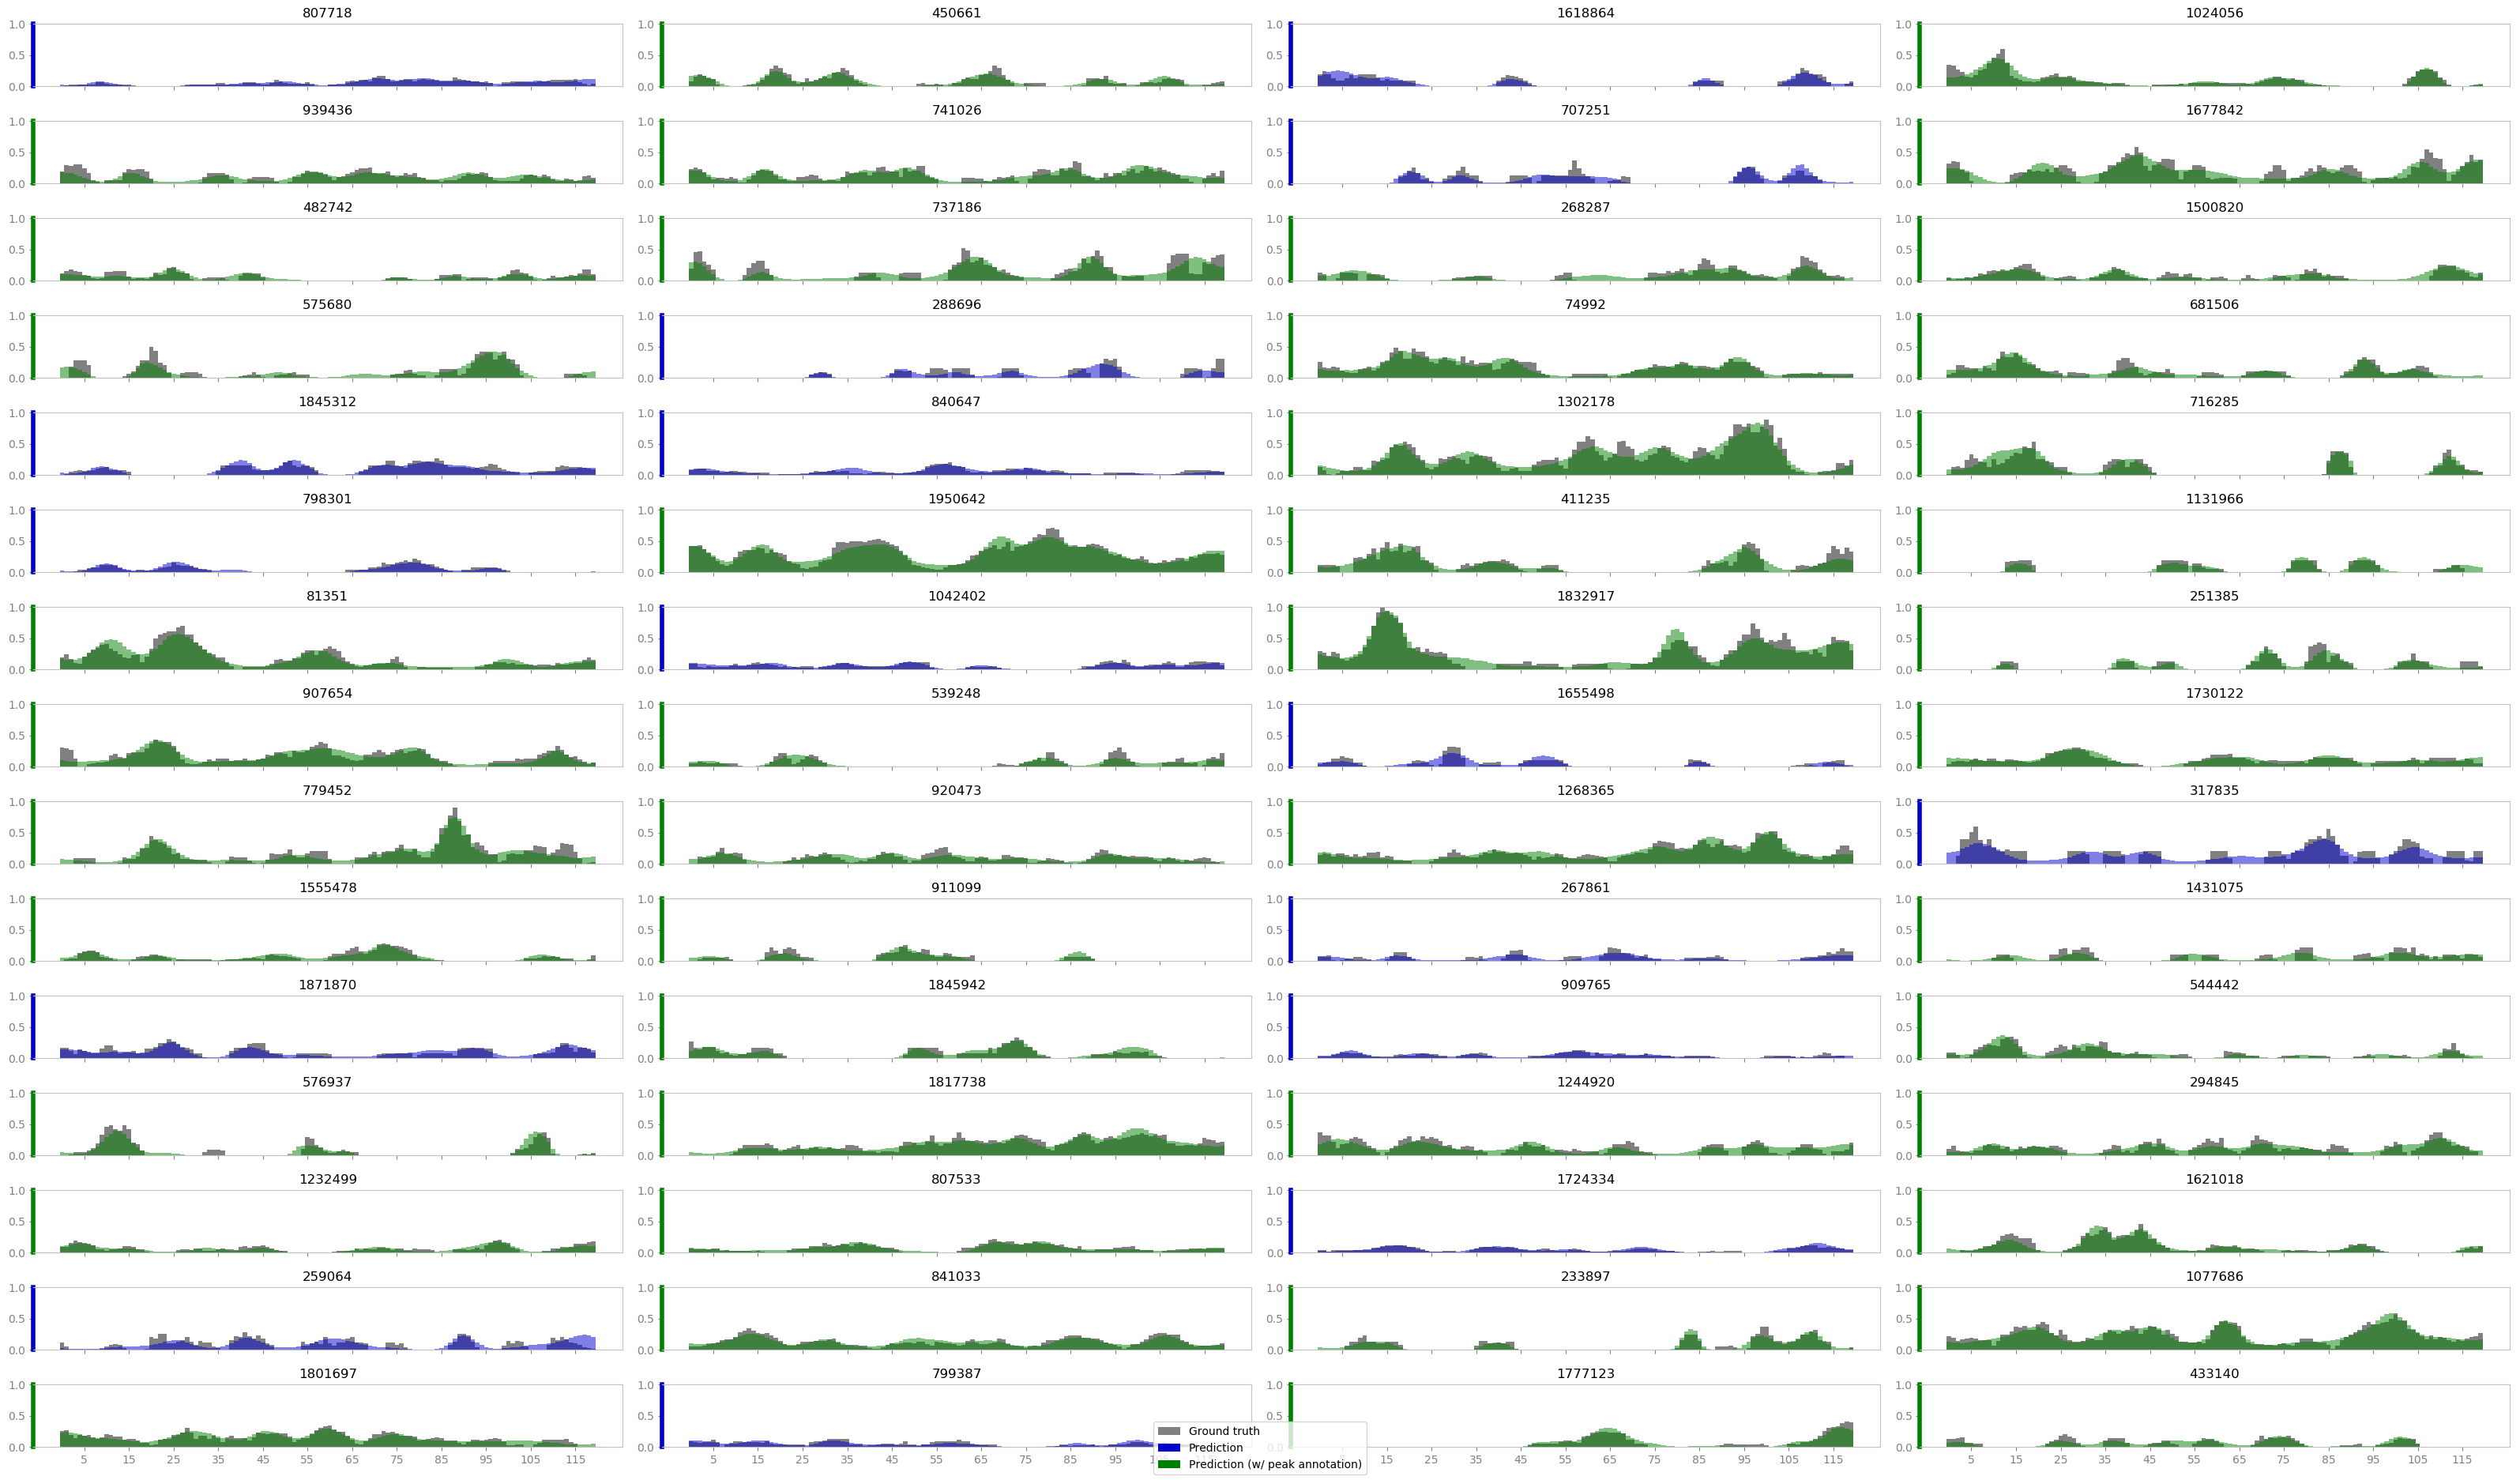

In [10]:
import h5py
from IPython.core.display import Image, display

with h5py.File(os.path.join(base, 'models', '{}---evaluation-{}-re-trained.h5'.format(model_name, dataset)), 'r') as f:
    print(np.mean(f['total_loss'], axis=0))
    print(f['total_times'][:])

display(Image(os.path.join(base, 'models', '{}---predictions-{}-re-trained.png'.format(model_name, dataset))))

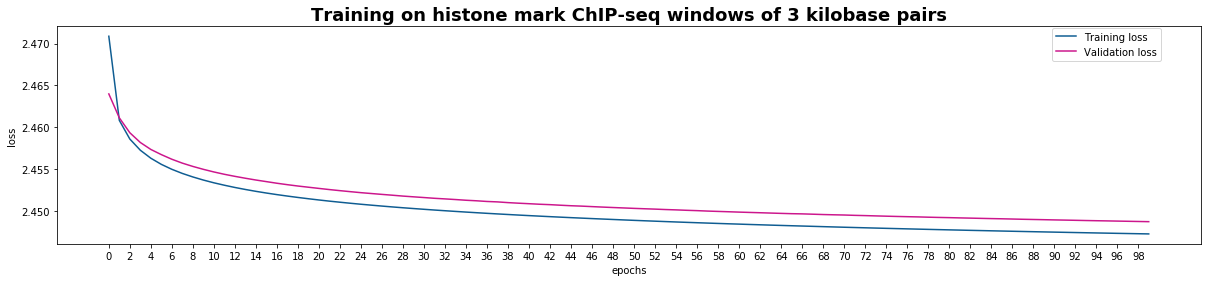

In [15]:
from train import plot_loss_to_file

with h5py.File(os.path.join(base, "models", "{}---training-{}-re-trained.h5".format(model_name, dataset)), "r") as f:
    plot_loss_to_file(
        f['loss'][:],
        f['val_loss'][:],
        model_name,
        dataset_name=dataset,
        title="Training on histone mark ChIP-seq windows of 3 kilobase pairs",
        base=base,
    )

## Plot individual windows

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


(array([1950642, 1077686, 1302178]),
 array([37.66849478, 28.54914105, 35.71556769]),
 array([0.71340269, 0.58184719, 0.88387012]))

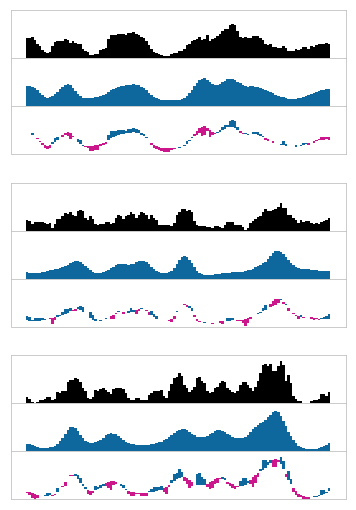

In [2]:
from ae.utils import plot_windows

plot_windows(
    dataset,
    model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0',
    ds_type="test",
    window_ids=[1950642, 1077686, 1302178],
    base=base,
    trained_on_single_dataset=True,
    re_trained=True,
    no_legend=True,
    no_peak_coloring=True,
    diff=True,
    plot_reconst_separately=True,
    no_title=True
)